In [1]:
# 生成数据集
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd,gluon,init,nd
from mxnet.gluon import data as gdata,loss as gloss,nn

n_train,n_test,num_inputs=20,100,200
true_w,true_b=nd.ones((num_inputs,1))*0.01,0.05
# y = 0.05 +∑0.01xi + ϵ 
features=nd.random.normal(shape=(n_train+n_test,num_inputs))
labels=nd.dot(features,true_w)+true_b
labels+=nd.random.normal(scale=0.01,shape=labels.shape)
train_features,test_features=features[:n_train,:],features[n_train:,:]
train_labels,test_labels=labels[:n_train],labels[n_train:]


In [2]:
# 3.12.3 从零开始实现 
# 初始化模型参数
def init_params():
    w =nd.random.normal(scale=1,shape=(num_inputs,1))
    b =nd.zeros(shape=(1,))
    w.attach_grad()
    b.attach_grad()
    return [w,b]

In [3]:
# 定义L2范数惩罚项
def l2_penalty(w):
    return (w**2).sum()/2

In [28]:
# 定义训练和测试
batch_size,num_epochs,lr=1,100,0.003
net,loss=d2l.linreg,d2l.squared_loss
train_iter=gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)

def fit_and_plot(lambd):
    w,b =init_params()
    train_ls,test_ls=[],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                # 添加了L2范数惩罚项
                l=loss(net(X,w,b),y)+lambd*l2_penalty(w)
            l.backward()
            d2l.sgd([w,b],lr,batch_size)
        train_ls.append( loss(net(train_features,w,b),train_labels).mean().asscalar() )
        test_ls.append( loss(net(test_features,w,b),test_labels).mean().asscalar() )
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',range(1,num_epochs+1),test_ls,['train','test'])
    print('L2 norm of w:',w.norm().asscalar(),',L2 norm of b:',b.norm().asscalar())

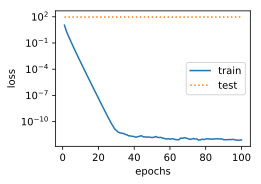

L2 norm of w: 13.671391 ,L2 norm of b: 0.071140125


In [29]:
# 观察过拟合
fit_and_plot(lambd=0)

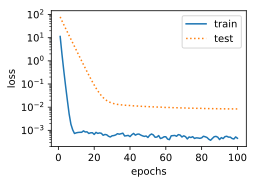

L2 norm of w: 0.043469984 ,L2 norm of b: 0.010688218


In [30]:
# 使用权重衰减
fit_and_plot(lambd=3)

In [45]:
# 3.12.4 简洁实现 
def fit_and_plot_gluon(wd):
    net=nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 通过wd参数来指定权重衰减超参数。默认下，Gluon会对权重和偏差同时衰减。
    # 分别对权重和偏差构造Trainer实例，从而只对权重衰减。 
    # 对权重参数衰减。net.collect_params(.*weight)收集所有以weight结尾的参数
    trainer_w=gluon.Trainer(net.collect_params('.*weight'),'sgd',{'learning_rate':lr,'wd':wd})
    # 不对偏差参数衰减。net.collect_params(.*bias)收集所有以weight结尾的参数
    trainer_b=gluon.Trainer(net.collect_params('.*bias'),'sgd',{'learning_rate':lr})
    train_ls,test_ls=[],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l=loss(net(X),y)
            l.backward()
            # 对两个Trainer实例分别调⽤step函数，从⽽分别更新权重和偏差 
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append( loss( net(train_features),train_labels ).mean().asscalar() )
        test_ls.append( loss(net(test_features),test_labels ).mean().asscalar() )
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',
                 range(1,num_epochs+1),test_ls,['train','test'])
    print('L2 norm of w;',net[0].weight.data().norm().asscalar(),'L2 norm of b;',net[0].bias.data().norm().asscalar())

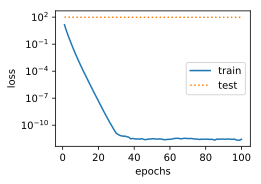

L2 norm of w; 14.5132675 L2 norm of b; 0.32127917


In [46]:
fit_and_plot_gluon(0)

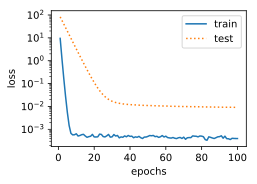

L2 norm of w; 0.043059554 L2 norm of b; 0.07806112


In [47]:
fit_and_plot_gluon(3)

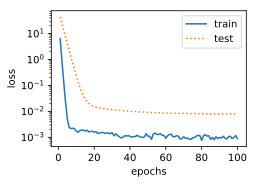

L2 norm of w; 0.03848536 L2 norm of b; 0.029722566


In [48]:
fit_and_plot_gluon(5)

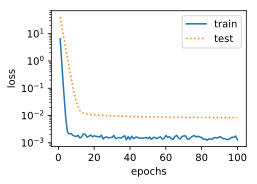

L2 norm of w; 0.035939187 L2 norm of b; 0.056362495


In [49]:
fit_and_plot_gluon(7)

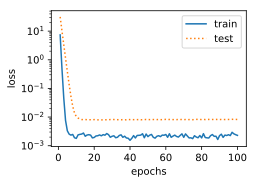

L2 norm of w; 0.030148255 L2 norm of b; 0.04941686


In [50]:
fit_and_plot_gluon(9)

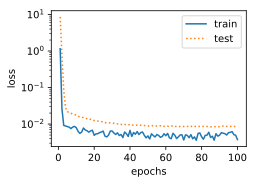

L2 norm of w; 0.025652943 L2 norm of b; 0.05138096


In [54]:
fit_and_plot_gluon(20)

In [43]:
net=nn.Sequential()
net.add(nn.Dense(1))
net.initialize(init.Normal(sigma=1))
net.collect_params??
gluon.Trainer.step??
nn.Dense??